In [808]:
#libraries
#import igor.igorpy as igor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import rpy2.robjects as robjects

#%matplotlib inline

In [667]:
#Functions

#Fxn to select waves for analysis
def indexWaves(df) :
    igorWaves = df.pivot(index='sec', columns='id', values='pA')
    waves = igorWaves.filter(waveInfo['waveName'])
    waves = waves.dropna(axis = 0)
    return(waves)

#Fxn to normalize traces
def normalizeTraces(df) :
    baseline = df[endCap:firstArtBegin]
    baseline = baseline.dropna(axis = 0)
    avgBaseline = baseline.apply(np.mean, axis = 0)
    normalizedTraces = wavesToAnalyze - avgBaseline
    return(normalizedTraces)

#Fxn to select specific traces by notes column
def wavesByNotes(df, info) :
    notesColumn = waveInfo.loc[:,['waveName', 'notes']]
    selectWaves = notesColumn.loc[notesColumn['notes'] == info]
    finalWaves = df.filter(selectWaves['waveName'])
    return(finalWaves)

#Fxn to find paired pulse ratio (second AMPA response / first AMPA response)
def findPPR(df1, df2) :
    #all AMPA amplitudes
    amplitudes = df1.apply(min)
    
    #identify waveName of max AMPA trace and select that wave
    findAMPAtrace = amplitudes[amplitudes.isin([min(amplitudes)])]
    findAMPAtrace = findAMPAtrace.dropna(axis = 0)
    maxAMPAtrace = df2.filter(findAMPAtrace.index)
    
    #calculate amplitude of second AMPA response
    secAMPAtrace = maxAMPAtrace[secStimBegin:secStimEnd]
    secAMPA = min(secAMPAtrace.apply(min))
    
    PPR = secAMPA / maxAMPA
    return(PPR)

#Fxn to pull out tau trace
def findTauTrace(df) :
    igorWaves = df.pivot(index='sec', columns='id', values='pA')
    notesColumn = waveInfo.loc[:,['waveName', 'notes']]
    selectWaves = notesColumn.loc[notesColumn['notes'] == 'NMDA tau']
    tauTrace = igorWaves.filter(selectWaves['waveName'])
    tauTrace = tauTrace.dropna(axis = 0)
    tauTrace = tauTrace[firstStimBegin:endTauTrace]
    tauTrace[firstArtBegin:firstArtEnd] = np.nan
    return(tauTrace)

In [884]:
#time points

#artifacts
firstArtBegin = 0.081 
firstArtEnd = 0.0845 #generally 0.0845
secArtBegin = 0.131
secArtEnd = 0.134

#traces
endCap = 0.02
firstStimBegin = 0.08
firstStimEnd = 0.125
secStimBegin = 0.136
secStimEnd = 0.175

endTauTrace = 0.58
beginTau = 0.115
endTau = 0.5

In [371]:
#load excel file
waveInfo = pd.read_excel('2016.10.26_Cell1.xlsx')
waveInfo.head()

,waveNum,waveName,stimInt,notes
0,1,w7,40.0,noBic
1,2,w8,40.0,noBic
2,3,w9,40.0,noBic
3,4,w10,40.0,noBic
4,5,w11,40.0,noBic


In [390]:
date = '2016.10.26'
cellNum = 1
age = 15

#Load csv
igor = pd.read_csv('igorForPython.csv', index_col = 0)
igor.head()

,id,sec,pA
1,w1,0.00000,5.283691
2,w1,0.00001,-0.965820
3,w1,0.00002,-4.403320
4,w1,0.00003,-6.590332
5,w1,0.00004,-5.653320


In [660]:
#Reformatting and selecting waves for analysis
wavesToAnalyze = indexWaves(igor)
wavesToAnalyze.head()

id,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,...,w75,w76,w77,w78,w79,w80,w81,w82,w83,w84
sec,,,,,,,,,,,,,,,,,,,,,
0.00000,0.948830,-3.059967,1.289867,-1.231331,-0.434429,2.303024,1.274933,0.613708,0.796894,1.317093,...,4.723364,1.359512,-1.399342,1.061974,1.475237,2.330578,-3.692544,-1.730488,-1.836338,-1.835079
0.00002,0.323860,-3.059967,-0.897526,-0.606361,-1.684368,2.615509,0.024994,0.301224,2.671803,2.567032,...,4.098394,1.359512,-1.711826,2.624397,0.850267,2.018093,-3.067575,-0.793034,-2.461308,-1.522594
0.00004,0.323860,-2.434998,0.039928,-0.293877,-1.996853,1.053085,0.649963,-0.636230,2.359318,2.567032,...,3.785910,1.359512,-1.711826,2.624397,2.412691,2.018093,-3.692544,-2.355457,-1.836338,-1.522594
0.00006,0.948830,-2.747482,0.039928,0.956062,-0.746914,0.740601,0.962448,0.613708,1.421864,1.942062,...,4.098394,1.671997,-1.086857,1.999428,0.850267,2.330578,-3.692544,-1.730488,-2.773792,-2.772533
0.00008,-0.301109,-1.185059,-1.210011,0.643578,-1.684368,2.303024,-0.287491,-0.011261,1.421864,3.504486,...,3.785910,1.047028,-1.711826,2.624397,1.162752,2.330578,-1.505151,-0.480549,-2.461308,-2.147564


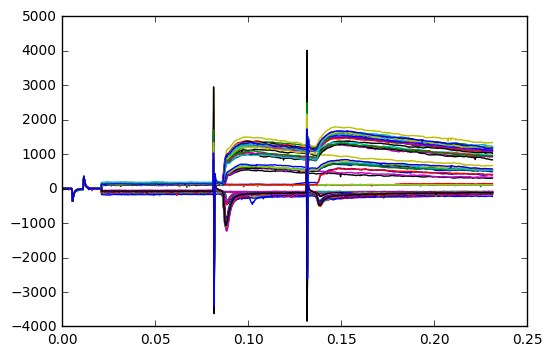

In [66]:
plt.plot(wavesToAnalyze)
plt.show()

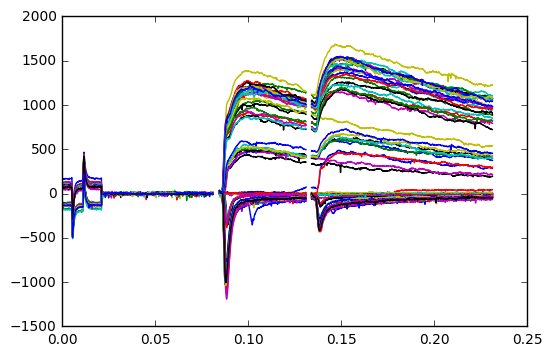

In [630]:
#remove stimulus artifacts
wavesToAnalyze[firstArtBegin:firstArtEnd] = np.nan
wavesToAnalyze[secArtBegin:secArtEnd] = np.nan

#normalize traces
normalized = normalizeTraces(wavesToAnalyze)
plt.plot(normalized)
plt.show()

In [549]:
#break data into diff sections
cap = wavesToAnalyze[0:endCap] #cap trace doesn't need to be normalized
firstStim = normalized[firstStimBegin:firstStimEnd]
bothStim = normalized[firstStimBegin:secStimEnd]

In [625]:
#select specific traces
inhTraces = wavesByNotes(firstStim, info = 'noBic')
SFs = wavesByNotes(bothStim, info = 'SF')
maximals = wavesByNotes(bothStim, info = 'max')
lastMax = wavesByNotes(bothStim, info = 'lastMax')

capSF = wavesByNotes(cap, info = 'SF')
capMax = wavesByNotes(cap, info = 'max')
capLastMax = wavesByNotes(cap, info = 'lastMax')

In [792]:
#Parameters to measure

#add smoothing

#maximals
maxNMDA = max(firstStim.apply(max))
maxAMPA = min(firstStim.apply(min))

ANRatio = abs(maxAMPA / maxNMDA)
PPR = findPPR(firstStim, bothStim)

#SFs
sfNMDA = max(SFs.apply(max))
sfAMPA = min(SFs.apply(min))

#FFs
FFampa = sfAMPA / maxAMPA
FFnmda = sfNMDA / maxNMDA
FFcell = (FFampa + FFnmda) / 2

#ADD TAU



In [793]:
#create data frame with all parameters

colNames = ['date', 'cellNum', 'age', 
            'maxAMPA', 'maxNMDA', 'ANRatio', 'PPR',
           'sfAMPA', 'sfNMDA',
           'FFampa', 'FFnmda', 'FFcell']

parameters = pd.DataFrame([[date, cellNum, age,
                           maxAMPA, maxNMDA, ANRatio, PPR,
                           sfAMPA, sfNMDA,
                           FFampa, FFnmda, FFcell]], 
                         columns = colNames)

parameters

,date,cellNum,age,maxAMPA,maxNMDA,ANRatio,PPR,sfAMPA,sfNMDA,FFampa,FFnmda,FFcell
0,2016.10.26,1,15,-1189.726536,1389.530604,0.856208,0.362805,-309.773406,489.005228,0.260374,0.351921,0.306147


In [ ]:
#append each cell as new row in parameters data frame
#for final analysis, filter by age, then calculate means of each column

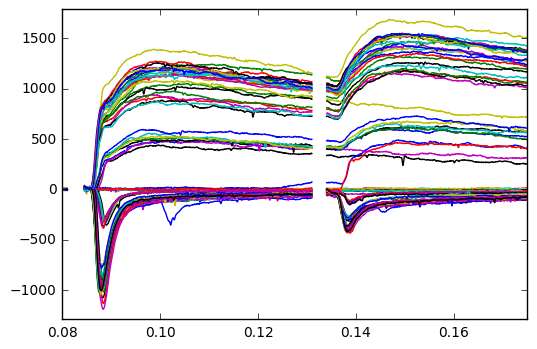

In [804]:
plt.plot(bothStim)
plt.axis([firstStimBegin, secStimEnd, round(maxAMPA) + -100, max(bothStim.apply(max)) + 100])
plt.show()

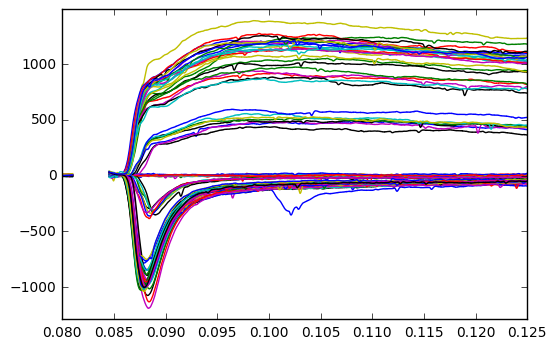

In [615]:
plt.plot(firstStim)
plt.axis([firstStimBegin, firstStimEnd, round(maxAMPA) + -100, round(maxNMDA) + 100])
plt.show()

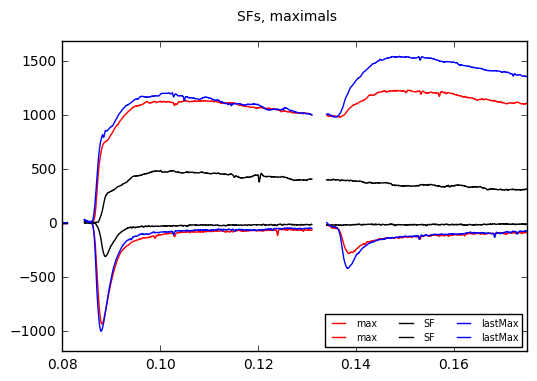

In [674]:
plt.plot(maximals, color = 'r', label = 'max')
plt.plot(SFs, color = 'k', label = 'SF')
plt.plot(lastMax, color = 'b', label = 'lastMax') 
plt.legend(loc = 4, fontsize = 'x-small', ncol = 3)
plt.axis([firstStimBegin, secStimEnd, round(maxAMPA), max(bothStim.apply(max))])
plt.suptitle('SFs, maximals')
plt.show()

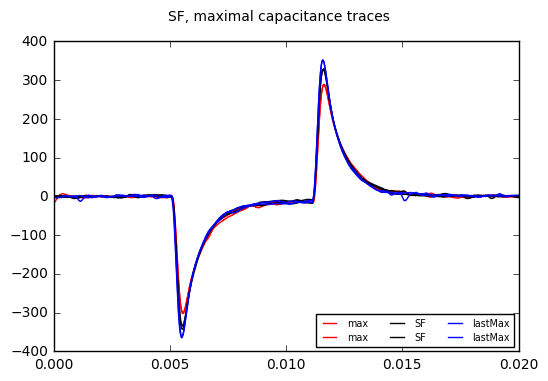

In [629]:
plt.plot(capMax, color = 'r', label = 'max')
plt.plot(capSF, color = 'k', label = 'SF')
plt.plot(capLastMax, color = 'b', label = 'lastMax') 
plt.legend(loc = 4, fontsize = 'x-small', ncol = 3)
plt.axis([0, endCap, -400, 400])
plt.suptitle('SF, maximal capacitance traces')
plt.show()

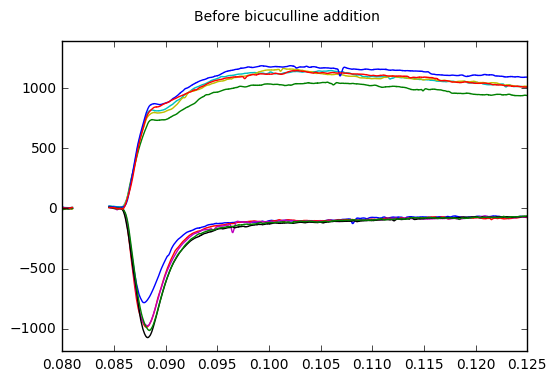

In [617]:
plt.plot(inhTraces)
plt.suptitle('Before bicuculline addition')
plt.axis([firstStimBegin, firstStimEnd, round(maxAMPA), round(maxNMDA)])
plt.show()

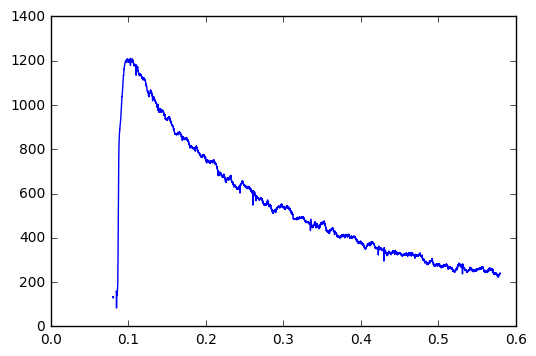

In [668]:
tauTrace = findTauTrace(igor)
plt.plot(tauTrace)
plt.show()

In [904]:
curveToFit = tauTrace[beginTau:endTau]
curveToFit.head()

id,w26
sec,
0.11500,1135.838501
0.11502,1135.838501
0.11504,1137.088501
0.11506,1136.776001
0.11508,1137.401001


In [902]:
pA = np.log(np.array(curveToFit['w26']))
pA
sec = np.array(curveToFit.index)
sec
N = 1000
smoothpA = np.convolve(pA, np.ones((N,))/N, mode='valid')
smoothsec = np.convolve(sec, np.ones((N,))/N, mode='valid')

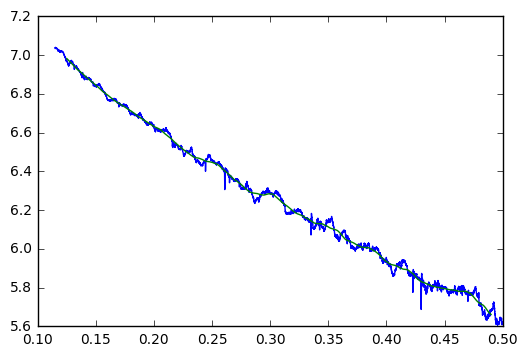

In [903]:
plt.plot(sec, pA)
plt.plot(smoothsec, smoothpA)
plt.show()

In [827]:
%load_ext rpy2.ipython

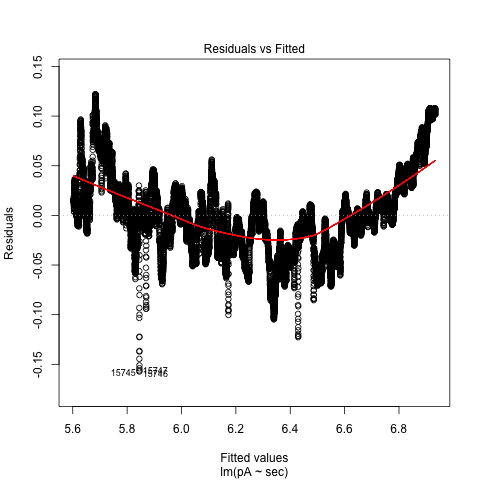

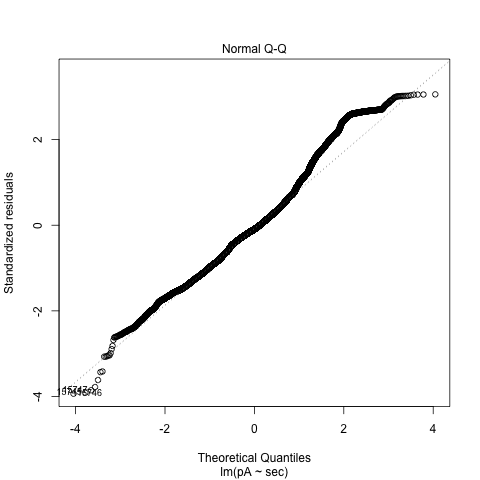

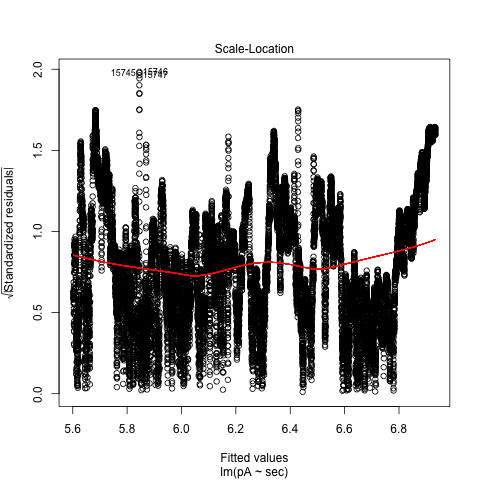

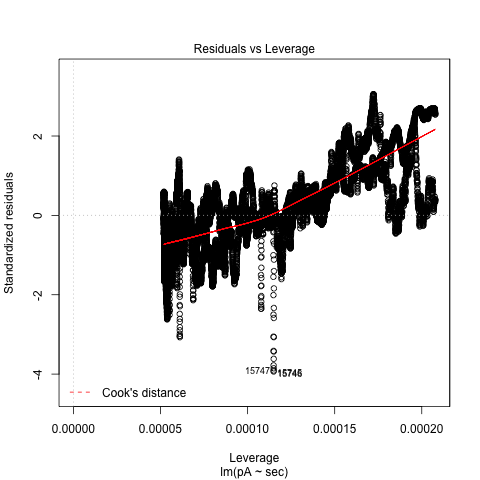

In [913]:
%%R -i pA,sec -o tauCoef
regModel = lm(pA ~ sec)
tauCoef = coef(regModel)
#par(mfrow=c(2,2))
plot(regModel)

In [906]:
%%R -i pA,sec -o tauCoef
regModel = lm(pA ~ sec)
tauCoef = coef(regModel)
summary(regModel)


Call:
lm(formula = pA ~ sec)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.157241 -0.027214 -0.003713  0.021119  0.122135 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.3310178  0.0008474    8651   <2e-16 ***
sec         -3.4564751  0.0025917   -1334   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03997 on 19249 degrees of freedom
Multiple R-squared:  0.9893,	Adjusted R-squared:  0.9893 
F-statistic: 1.779e+06 on 1 and 19249 DF,  p-value: < 2.2e-16



In [905]:
1 / tauCoef[1]

-0.28931208131078973